In [ ]:
#This code goes after the 1_Preprocessing notebook. It is splitted for the sake of clarity. 
#In order to make it functional just paste it after the previous notebook

## Splits train and hold out test

In [38]:
NHC = train_df_filt_norm.Filename.str.split(pat="_", expand=True)

In [39]:
len(NHC[0].unique())

6123

In [40]:
train, test = model_selection.train_test_split(NHC[0].unique(), train_size=0.9, random_state=42)

In [41]:
len(train), len(test)

(5510, 613)

In [42]:
train_df_filt_norm['NHC'] = NHC[0]

In [43]:
train_df_filt_norm['Filename'] = 'images/' + train_df_filt_norm['Filename'].astype(str)

In [44]:
x_train = train_df_filt_norm[train_df_filt_norm['NHC'].isin(train)]

Control          5333
COVID            1067
Heart_failure     913
Pneumonia         442
Name: Label, dtype: int64

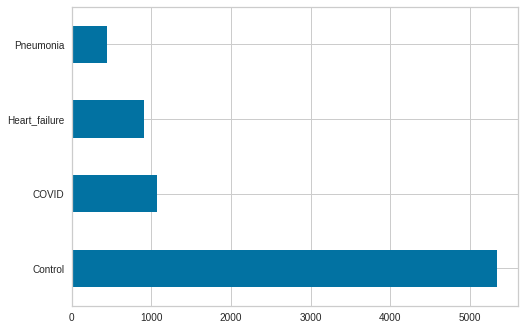

In [45]:
x_train['Label'].value_counts().plot(kind='barh'); x_train['Label'].value_counts()

In [46]:
x_train.NHC.unique()

array(['1000029', '1000388', '100315', ..., '740776', '852490', '94824'],
      dtype=object)

In [47]:
x_test = train_df_filt_norm[train_df_filt_norm['NHC'].isin(test)]

Control          576
COVID            104
Heart_failure     95
Pneumonia         48
Name: Label, dtype: int64

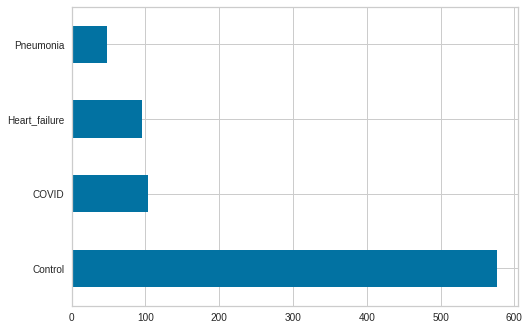

In [49]:
x_test['Label'].value_counts().plot(kind='barh'); x_test['Label'].value_counts()

## Split training set with 5 different random seeds

In [58]:
#Create patient aware splits
train_0, valid_0 = model_selection.train_test_split(x_train.NHC.unique(), train_size=0.8, random_state=21)
train_1, valid_1 = model_selection.train_test_split(x_train.NHC.unique(), train_size=0.8, random_state=42)
train_2, valid_2 = model_selection.train_test_split(x_train.NHC.unique(), train_size=0.8, random_state=84)
train_3, valid_3 = model_selection.train_test_split(x_train.NHC.unique(), train_size=0.8, random_state=168)
train_4, valid_4 = model_selection.train_test_split(x_train.NHC.unique(), train_size=0.8, random_state=336)

In [59]:
#Create validation sets
x_valid_0 = x_train[x_train['NHC'].isin(valid_0)]
x_valid_1 = x_train[x_train['NHC'].isin(valid_1)]
x_valid_2 = x_train[x_train['NHC'].isin(valid_2)]
x_valid_3 = x_train[x_train['NHC'].isin(valid_3)]
x_valid_4 = x_train[x_train['NHC'].isin(valid_4)]

In [60]:
pd.options.mode.chained_assignment = None  # default='warn'
x_valid_0['is_valid'] = True
x_valid_1['is_valid'] = True
x_valid_2['is_valid'] = True
x_valid_3['is_valid'] = True
x_valid_4['is_valid'] = True
pd.options.mode.chained_assignment = 'warn'

Control          1080
COVID             199
Heart_failure     178
Pneumonia         105
Name: Label, dtype: int64

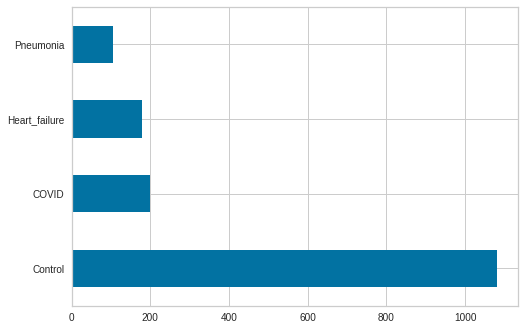

In [61]:
x_valid_0['Label'].value_counts().plot(kind='barh'); x_valid_0['Label'].value_counts()

In [63]:
x_train_0 = x_train[x_train['NHC'].isin(train_0)]
x_train_1 = x_train[x_train['NHC'].isin(train_1)]
x_train_2 = x_train[x_train['NHC'].isin(train_2)]
x_train_3 = x_train[x_train['NHC'].isin(train_3)]
x_train_4 = x_train[x_train['NHC'].isin(train_4)]

In [64]:
pd.options.mode.chained_assignment = None  # default='warn'
x_train_0['is_valid'] = False
x_train_1['is_valid'] = False
x_train_2['is_valid'] = False
x_train_3['is_valid'] = False
x_train_4['is_valid'] = False
pd.options.mode.chained_assignment = 'warn'

Control          4253
COVID             868
Heart_failure     735
Pneumonia         337
Name: Label, dtype: int64

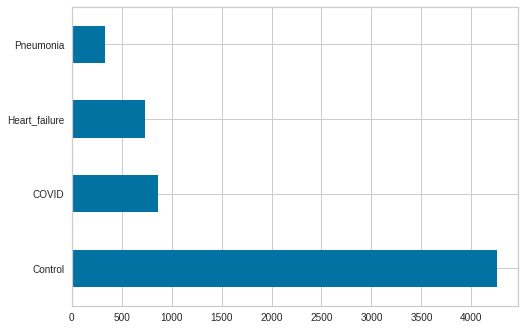

In [65]:
x_train_0['Label'].value_counts().plot(kind='barh'); x_train_0['Label'].value_counts()

In [67]:
x_train_0 = pd.concat([x_train_0, x_valid_0])
x_train_1 = pd.concat([x_train_1, x_valid_1])
x_train_2 = pd.concat([x_train_2, x_valid_2])
x_train_3 = pd.concat([x_train_3, x_valid_3])
x_train_4 = pd.concat([x_train_4, x_valid_4])

## Recreate the single vision learner and train

In [68]:
get_x = lambda x:path/f'{x[0]}'
get_y=ColReader('Label')
batch_tfms = aug_transforms(flip_vert=False,do_flip=False)
#blocks = (ImageBlock(cls=PILDicom), CategoryBlock(vocab=[0,1]))
splitter = ColSplitter()
CXR_db = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_x = get_x,
                   get_y     = ColReader('Label'),
                   #item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   #batch_tfms=Normalize.from_stats(*imagenet_stats)
                   splitter = splitter,
                   item_tfms = Resize(512),
                   batch_tfms = batch_tfms
                  )

In [69]:
vis_dl_0 = CXR_db.dataloaders(x_train_0, bs=8)
vis_dl_1 = CXR_db.dataloaders(x_train_1, bs=8)
vis_dl_2 = CXR_db.dataloaders(x_train_2, bs=8)
vis_dl_3 = CXR_db.dataloaders(x_train_3, bs=8)
vis_dl_4 = CXR_db.dataloaders(x_train_4, bs=8)

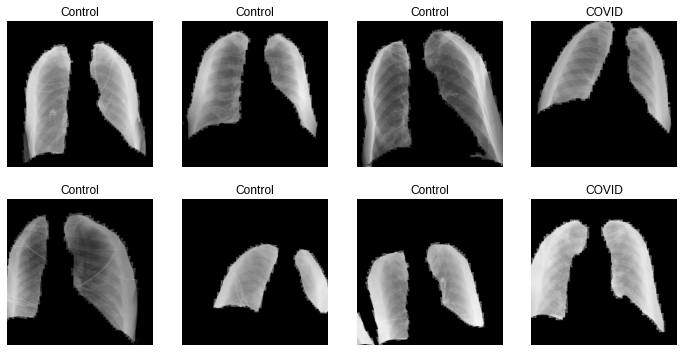

In [70]:
vis_dl_0.show_batch()

In [72]:
vis_learn_0 = cnn_learner(vis_dl_0, resnet34, metrics=[accuracy, RocAuc()], pretrained=True)
vis_learn_1 = cnn_learner(vis_dl_1, resnet34, metrics=[accuracy, RocAuc()], pretrained=True)
vis_learn_2 = cnn_learner(vis_dl_2, resnet34, metrics=[accuracy, RocAuc()], pretrained=True)
vis_learn_3 = cnn_learner(vis_dl_3, resnet34, metrics=[accuracy, RocAuc()], pretrained=True)
vis_learn_4 = cnn_learner(vis_dl_4, resnet34, metrics=[accuracy, RocAuc()], pretrained=True)

In [78]:
#Since the dataset if highly imbalanced, as set of weigths are added to the loss function in order to reduce this issue

In [79]:
from collections import Counter

In [80]:
#FROM HERE: https://forums.fast.ai/t/oversampling-in-fastai2/73721/11?u=joan
#Get weights based on the class distribution in the training data
def get_weights(dls):
   
    # 0th index would provide the vocab from text
    # 1st index would provide the vocab from classes
    classes = dls.vocab

    #Get label ids from the dataset using map
    #train_lb_ids = L(map(lambda x: x[1], dls.train_ds))
    # Get the actual labels from the label_ids & the vocab
    #train_lbls = L(map(lambda x: classes[x], train_lb_ids))

    #Combine the above into a single
    train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
    label_counter = Counter(train_lbls)
    n_most_common_class = max(label_counter.values()); 
    print(f'Occurrences of the most common class {n_most_common_class}')
    
    # Source: https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/9
    weights = [n_most_common_class/v for k, v in label_counter.items() if v > 0]; return weights 

In [81]:
#This calculatios was performed beforehand
# weights_0 = get_weights(vis_dl_0) 
# weights_1 = get_weights(vis_dl_1) 
# weights_2 = get_weights(vis_dl_2) 
# weights_3 = get_weights(vis_dl_3) 
# weights_4 = get_weights(vis_dl_4) 

In [82]:
vis_dl_0.vocab

(#4) ['COVID','Control','Heart_failure','Pneumonia']

In [83]:
weights_0, weights_1, weights_2, weights_3, weights_4 = ([1.0, 12.620178041543026, 4.899769585253456, 5.7863945578231295],
 [1.0, 11.974719101123595, 5.044970414201184, 5.784260515603799],
 [1.0, 12.073446327683616, 4.963995354239256, 5.767881241565452],
 [1.0, 11.726775956284152, 4.984901277584204, 5.9694019471488176],
 [1.0, 11.457219251336898, 4.994172494172494, 5.926694329183956])

In [84]:
# weights_0, weights_1, weights_2, weights_3, weights_4 = ([1.0, 11.671195652173912, 4.959584295612009, 5.907840440165062],
#  [1.0, 11.225464190981432, 4.803632236095346, 5.635153129161118],
#  [1.0, 11.010335917312661, 5.024764150943396, 5.742587601078167],
#  [1.0, 12.0, 4.989399293286219, 5.778990450204638],
#  [1.0, 11.6775956284153, 4.998830409356725, 5.911479944674966])

In [85]:
#Here reorder the factors to fit .vocab
myorder = [2, 0, 3, 1]
ord_weights_0 = [weights_0[i] for i in myorder]
ord_weights_1 = [weights_1[i] for i in myorder]
ord_weights_2 = [weights_2[i] for i in myorder]
ord_weights_3 = [weights_3[i] for i in myorder]
ord_weights_4 = [weights_4[i] for i in myorder]


In [86]:
class_weights_0 = torch.FloatTensor(ord_weights_0).to(vis_dl_0.device)
class_weights_1 = torch.FloatTensor(ord_weights_1).to(vis_dl_1.device)
class_weights_2 = torch.FloatTensor(ord_weights_2).to(vis_dl_2.device)
class_weights_3 = torch.FloatTensor(ord_weights_3).to(vis_dl_3.device)
class_weights_4 = torch.FloatTensor(ord_weights_4).to(vis_dl_4.device)


In [65]:
#Upload the weights to the loss function
class_weights_0 = torch.FloatTensor(ord_weights_0).to(vis_dl_0.device)
vis_learn_0.loss_func = CrossEntropyLossFlat(weight=class_weights_0)
vis_learn_0.fine_tune(30, freeze_epochs=30, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_0')])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.935653,2.066513,0.241997,0.610684,01:08
1,1.698436,1.557096,0.352753,0.668828,01:07
2,1.841823,1.297337,0.439181,0.699292,01:07
3,1.562822,1.232476,0.467350,0.705924,01:07
4,1.511155,1.472154,0.361076,0.710172,01:08
5,1.456691,1.355459,0.407811,0.721701,01:08
6,1.413897,1.280057,0.458387,0.716596,01:08
7,1.370960,1.340570,0.410371,0.743909,01:08
8,1.183488,1.260569,0.428937,0.721565,01:08
9,1.098003,0.993402,0.582586,0.757731,01:08


Better model found at epoch 0 with accuracy value: 0.24199743568897247.
Better model found at epoch 1 with accuracy value: 0.3527528941631317.
Better model found at epoch 2 with accuracy value: 0.43918052315711975.
Better model found at epoch 3 with accuracy value: 0.4673495590686798.
Better model found at epoch 9 with accuracy value: 0.582586407661438.
Better model found at epoch 10 with accuracy value: 0.617157518863678.
Better model found at epoch 11 with accuracy value: 0.6402048468589783.
Better model found at epoch 12 with accuracy value: 0.7042253613471985.
Better model found at epoch 20 with accuracy value: 0.7151088118553162.
Better model found at epoch 28 with accuracy value: 0.7183098793029785.
Better model found at epoch 29 with accuracy value: 0.7195902466773987.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.943433,0.809924,0.674776,0.853417,01:31
1,0.884950,0.860640,0.633803,0.853760,01:30
2,0.962775,0.806425,0.663252,0.857963,01:31
3,0.829328,0.720245,0.709347,0.878971,01:30
4,0.820808,0.730440,0.734955,0.861322,01:30
5,0.886865,0.703821,0.747119,0.873897,01:31
6,0.863271,0.795528,0.701665,0.852678,01:31
7,0.854637,0.669018,0.749680,0.878717,01:31
8,0.843450,0.751291,0.709347,0.879170,01:31
9,0.812986,0.690635,0.747759,0.883160,01:31


Better model found at epoch 0 with accuracy value: 0.6747759580612183.
Better model found at epoch 3 with accuracy value: 0.7093470096588135.
Better model found at epoch 4 with accuracy value: 0.7349551916122437.
Better model found at epoch 5 with accuracy value: 0.7471190690994263.
Better model found at epoch 7 with accuracy value: 0.7496799230575562.
Better model found at epoch 12 with accuracy value: 0.7682458162307739.
Better model found at epoch 17 with accuracy value: 0.7720870971679688.
Better model found at epoch 19 with accuracy value: 0.7765684723854065.
Better model found at epoch 20 with accuracy value: 0.7893726229667664.
Better model found at epoch 21 with accuracy value: 0.791293203830719.
Better model found at epoch 25 with accuracy value: 0.8040972948074341.


In [66]:
#And upload the weights to the loss function
class_weights_1 = torch.FloatTensor(ord_weights_1).to(vis_dl_1.device)
vis_learn_1.loss_func = CrossEntropyLossFlat(weight=class_weights_1)
vis_learn_1.fine_tune(30, freeze_epochs=30, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_1')])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,2.061792,1.812561,0.241956,0.612470,01:08
1,1.731332,1.537853,0.332046,0.656073,01:07
2,1.729553,1.430949,0.402831,0.686209,01:07
3,1.676811,1.247827,0.440154,0.708292,01:08
4,1.518582,1.062290,0.572716,0.715319,01:08
5,1.520198,1.054738,0.553411,0.713715,01:08
6,1.231310,1.073743,0.546976,0.716139,01:08
7,1.207616,1.366630,0.377735,0.724424,01:07
8,1.270513,1.085247,0.537967,0.743933,01:07
9,1.141093,1.353375,0.415701,0.741187,01:08


Better model found at epoch 0 with accuracy value: 0.24195624887943268.
Better model found at epoch 1 with accuracy value: 0.3320463299751282.
Better model found at epoch 2 with accuracy value: 0.40283140540122986.
Better model found at epoch 3 with accuracy value: 0.44015443325042725.
Better model found at epoch 4 with accuracy value: 0.5727155804634094.
Better model found at epoch 11 with accuracy value: 0.6685971617698669.
Better model found at epoch 17 with accuracy value: 0.6943371891975403.
Better model found at epoch 20 with accuracy value: 0.7252252101898193.
Better model found at epoch 26 with accuracy value: 0.7438867688179016.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.906842,0.721342,0.714929,0.875730,01:31
1,0.996052,0.682872,0.723938,0.886262,01:31
2,1.053735,0.740741,0.694337,0.871632,01:31
3,0.802883,0.586505,0.780566,0.900859,01:32
4,0.847084,0.734828,0.696268,0.890532,01:31
5,0.881646,0.803173,0.662806,0.881531,01:31
6,0.852960,0.687781,0.710425,0.893662,01:31
7,0.779492,0.684981,0.738739,0.890902,01:31
8,0.781695,0.668638,0.727799,0.901775,01:31
9,0.792045,0.653701,0.742600,0.902333,01:31


Better model found at epoch 0 with accuracy value: 0.7149292230606079.
Better model found at epoch 1 with accuracy value: 0.7239382266998291.
Better model found at epoch 3 with accuracy value: 0.7805662751197815.
No improvement since epoch 3: early stopping


In [67]:
#And upload the weights to the loss function
class_weights_2 = torch.FloatTensor(ord_weights_2).to(vis_dl_2.device)
vis_learn_2.loss_func = CrossEntropyLossFlat(weight=class_weights_2)
vis_learn_2.fine_tune(30, freeze_epochs=30, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_2')])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.958958,1.497748,0.337705,0.616075,01:08
1,1.862990,1.362960,0.393443,0.647503,01:08
2,1.727266,1.432803,0.398033,0.688227,01:08
3,1.555458,1.056507,0.567213,0.717742,01:08
4,1.528082,1.203149,0.451148,0.698282,01:08
5,1.378952,1.375271,0.373115,0.705428,01:09
6,1.284097,1.174306,0.454426,0.716778,01:08
7,1.273760,1.151069,0.487213,0.714228,01:10
8,1.237233,1.079196,0.533115,0.726767,01:08
9,1.234341,0.954315,0.601967,0.744293,01:08


Better model found at epoch 0 with accuracy value: 0.33770492672920227.
Better model found at epoch 1 with accuracy value: 0.39344263076782227.
Better model found at epoch 2 with accuracy value: 0.3980327844619751.
Better model found at epoch 3 with accuracy value: 0.5672131180763245.
Better model found at epoch 9 with accuracy value: 0.6019672155380249.
Better model found at epoch 13 with accuracy value: 0.6662294864654541.
Better model found at epoch 17 with accuracy value: 0.6701639294624329.
Better model found at epoch 18 with accuracy value: 0.7081966996192932.
Better model found at epoch 21 with accuracy value: 0.7154098153114319.
Better model found at epoch 23 with accuracy value: 0.7245901823043823.
Better model found at epoch 26 with accuracy value: 0.7442622780799866.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.949027,0.731107,0.722623,0.856938,01:33
1,0.941446,0.666847,0.758689,0.871325,01:32
2,0.842798,0.783807,0.663607,0.849820,01:32
3,0.839812,0.982669,0.573770,0.835810,01:32
4,0.892984,0.745523,0.719344,0.847689,01:32
5,0.809771,0.732115,0.733115,0.852289,01:33
6,0.860127,0.825764,0.643279,0.860026,01:34
7,0.843530,0.686686,0.752131,0.869030,01:33
8,0.807721,0.735156,0.706885,0.861157,01:34
9,0.908039,0.662674,0.766557,0.871536,01:32


Better model found at epoch 0 with accuracy value: 0.7226229310035706.
Better model found at epoch 1 with accuracy value: 0.7586885094642639.
Better model found at epoch 9 with accuracy value: 0.7665573954582214.
Better model found at epoch 11 with accuracy value: 0.7803278565406799.
Better model found at epoch 21 with accuracy value: 0.7881967425346375.
Better model found at epoch 22 with accuracy value: 0.8032786846160889.


In [68]:
#And upload the weights to the loss function
class_weights_3 = torch.FloatTensor(ord_weights_3).to(vis_dl_3.device)
vis_learn_3.loss_func = CrossEntropyLossFlat(weight=class_weights_3)
vis_learn_3.fine_tune(30, freeze_epochs=30, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_3')])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,2.005840,1.983806,0.250494,0.627120,01:08
1,1.726384,1.836666,0.241925,0.651218,01:10
2,1.664094,1.545560,0.340145,0.684552,01:09
3,1.477201,1.259724,0.448912,0.697383,01:10
4,1.524484,1.180630,0.488464,0.698378,01:08
5,1.373280,1.309029,0.431773,0.701432,01:09
6,1.347890,1.037594,0.558998,0.721326,01:09
7,1.199660,1.251474,0.447594,0.741890,01:09
8,1.212709,1.181045,0.462755,0.744464,01:09
9,1.215747,1.042479,0.544496,0.750263,01:08


Better model found at epoch 0 with accuracy value: 0.2504943907260895.
Better model found at epoch 2 with accuracy value: 0.3401450216770172.
Better model found at epoch 3 with accuracy value: 0.4489123225212097.
Better model found at epoch 4 with accuracy value: 0.4884640872478485.
Better model found at epoch 6 with accuracy value: 0.5589980483055115.
Better model found at epoch 13 with accuracy value: 0.5833882689476013.
Better model found at epoch 14 with accuracy value: 0.6690837144851685.
Better model found at epoch 18 with accuracy value: 0.7092946767807007.
Better model found at epoch 25 with accuracy value: 0.7376400828361511.
Better model found at epoch 27 with accuracy value: 0.7442320585250854.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.965965,0.819182,0.646671,0.868890,01:33
1,0.873280,0.752224,0.671061,0.876250,01:33
2,1.010463,0.751279,0.674357,0.859500,01:33
3,0.849054,0.640146,0.731707,0.885730,01:33
4,0.932298,0.779217,0.656559,0.860369,01:33
5,0.839948,0.687477,0.742914,0.885341,01:33
6,0.913899,0.666571,0.758075,0.871280,01:33
7,0.835857,0.696549,0.715887,0.885542,01:33
8,0.936129,0.625240,0.750165,0.897103,01:34
9,0.745135,0.669498,0.731048,0.889453,01:33


Better model found at epoch 0 with accuracy value: 0.6466710567474365.
Better model found at epoch 1 with accuracy value: 0.6710612773895264.
Better model found at epoch 2 with accuracy value: 0.6743572950363159.
Better model found at epoch 3 with accuracy value: 0.7317073345184326.
Better model found at epoch 5 with accuracy value: 0.7429136633872986.
Better model found at epoch 6 with accuracy value: 0.7580751776695251.
Better model found at epoch 10 with accuracy value: 0.7587343454360962.
Better model found at epoch 14 with accuracy value: 0.7699406743049622.
Better model found at epoch 16 with accuracy value: 0.7811470031738281.
Better model found at epoch 17 with accuracy value: 0.7897165417671204.
Better model found at epoch 18 with accuracy value: 0.7989453077316284.
Better model found at epoch 25 with accuracy value: 0.8042188286781311.
Better model found at epoch 26 with accuracy value: 0.8048780560493469.
Better model found at epoch 27 with accuracy value: 0.805537223815918.

In [69]:
#And upload the weights to the loss function
class_weights_4 = torch.FloatTensor(ord_weights_4).to(vis_dl_4.device)
vis_learn_4.loss_func = CrossEntropyLossFlat(weight=class_weights_4)
vis_learn_4.fine_tune(30, freeze_epochs=30, 
                      cbs=[EarlyStoppingCallback(monitor='accuracy', patience=10), 
                           SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_VIS_4')])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.839773,1.565565,0.353135,0.640846,01:09
1,1.832509,1.517816,0.351815,0.674678,01:09
2,1.742030,1.301151,0.458086,0.694541,01:09
3,1.439384,1.379711,0.400660,0.701372,01:09
4,1.434998,1.293273,0.436304,0.727609,01:09
5,1.483370,1.046302,0.537954,0.728874,01:09
6,1.323978,0.979018,0.610561,0.727891,01:09
7,1.159487,1.018835,0.576898,0.719560,01:10
8,1.184475,0.972873,0.598680,0.752943,01:09
9,1.122219,0.936063,0.627723,0.740005,01:09


Better model found at epoch 0 with accuracy value: 0.3531353175640106.
Better model found at epoch 2 with accuracy value: 0.4580858051776886.
Better model found at epoch 5 with accuracy value: 0.537953794002533.
Better model found at epoch 6 with accuracy value: 0.6105610728263855.
Better model found at epoch 9 with accuracy value: 0.6277227997779846.
Better model found at epoch 11 with accuracy value: 0.6343234181404114.
Better model found at epoch 12 with accuracy value: 0.6963696479797363.
Better model found at epoch 17 with accuracy value: 0.7069306969642639.
Better model found at epoch 23 with accuracy value: 0.7095709443092346.
Better model found at epoch 24 with accuracy value: 0.7287128567695618.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.987580,0.741612,0.734653,0.855477,01:32
1,1.018661,0.728070,0.718812,0.869405,01:32
2,0.885071,0.881713,0.619802,0.850402,01:33
3,0.882772,0.789418,0.689109,0.831371,01:33
4,0.907173,0.751026,0.693069,0.877537,01:33
5,0.912281,0.905970,0.636304,0.850858,01:33
6,0.939147,0.707976,0.735314,0.856594,01:32
7,0.934736,0.707660,0.714851,0.885156,01:33
8,0.763740,0.691865,0.758416,0.848187,01:33
9,0.826334,0.605740,0.769637,0.887930,01:34


Better model found at epoch 0 with accuracy value: 0.7346534729003906.
Better model found at epoch 6 with accuracy value: 0.7353135347366333.
Better model found at epoch 8 with accuracy value: 0.7584158182144165.
Better model found at epoch 9 with accuracy value: 0.7696369886398315.
Better model found at epoch 12 with accuracy value: 0.7716171741485596.
Better model found at epoch 14 with accuracy value: 0.7867986559867859.
Better model found at epoch 15 with accuracy value: 0.7986798882484436.
Better model found at epoch 17 with accuracy value: 0.8006600737571716.
Better model found at epoch 19 with accuracy value: 0.801980197429657.
Better model found at epoch 22 with accuracy value: 0.8099009990692139.
Better model found at epoch 25 with accuracy value: 0.8112211227416992.
Better model found at epoch 27 with accuracy value: 0.8118811845779419.
Better model found at epoch 28 with accuracy value: 0.8138613700866699.


## Recreate the single tabular learner and train

In [87]:
x_train_0.columns

Index(['Filename', 'Label', 'Edad', 'Sexe', 'BASFILS', 'BASFILS_T',
       'EOSINFILS_T', 'H._C._M.', 'HEMATIES', 'HEMOGLOBINA', 'LEUCCITS',
       'LIMFCITS_T', 'M._C._H._C.', 'MONCITS', 'MONCITS_T', 'NEUTRFILS',
       'NEUTRFILS_T', 'PLAQUETES', 'RDW-CV', 'RDW-SD', 'V._C._M.', 'V._P._M.',
       'NHC', 'is_valid'],
      dtype='object')

In [88]:
cols = ['Sexe','Label', 'BASFILS', 'BASFILS_T',
       'EOSINFILS_T', 'H._C._M.', 'HEMATIES',
       'HEMOGLOBINA', 'LEUCCITS', 'LIMFCITS_T', 'M._C._H._C.',
       'MONCITS', 'MONCITS_T', 'NEUTRFILS', 'NEUTRFILS_T',
       'PLAQUETES', 'RDW-CV', 'RDW-SD', 'V._C._M.', 'V._P._M.','is_valid']

In [89]:
df_0 = x_train_0[cols]
df_1 = x_train_1[cols]
df_2 = x_train_2[cols]
df_3 = x_train_3[cols]
df_4 = x_train_4[cols]

In [90]:
cont_cat_split(df_0)

(['BASFILS',
  'BASFILS_T',
  'EOSINFILS_T',
  'H._C._M.',
  'HEMATIES',
  'HEMOGLOBINA',
  'LEUCCITS',
  'LIMFCITS_T',
  'M._C._H._C.',
  'MONCITS',
  'MONCITS_T',
  'NEUTRFILS',
  'NEUTRFILS_T',
  'PLAQUETES',
  'RDW-CV',
  'RDW-SD',
  'V._C._M.',
  'V._P._M.'],
 ['Sexe', 'Label', 'is_valid'])

In [91]:
#In previous analysis we found that "Edad" was so much correlated with Heart attack, so we drop it
procs = [Categorify, FillMissing, Normalize]
cat_names  = ['Sexe']
cont_names = ['BASFILS', 'BASFILS_T',
       'EOSINFILS_T', 'H._C._M.', 'HEMATIES',
       'HEMOGLOBINA', 'LEUCCITS', 'LIMFCITS_T', 'M._C._H._C.',
       'MONCITS', 'MONCITS_T', 'NEUTRFILS', 'NEUTRFILS_T',
       'PLAQUETES', 'RDW-CV', 'RDW-SD', 'V._C._M.', 'V._P._M.']
splitter_0 = ColSplitter()(df_0)
splitter_1 = ColSplitter()(df_1)
splitter_2 = ColSplitter()(df_2)
splitter_3 = ColSplitter()(df_3)
splitter_4 = ColSplitter()(df_4)

In [92]:
to_0 = TabularPandas(df_0, procs, cat_names, cont_names, y_names='Label', y_block=CategoryBlock(), splits=splitter_0)
to_1 = TabularPandas(df_1, procs, cat_names, cont_names, y_names='Label', y_block=CategoryBlock(), splits=splitter_1)
to_2 = TabularPandas(df_2, procs, cat_names, cont_names, y_names='Label', y_block=CategoryBlock(), splits=splitter_2)
to_3 = TabularPandas(df_3, procs, cat_names, cont_names, y_names='Label', y_block=CategoryBlock(), splits=splitter_3)
to_4 = TabularPandas(df_4, procs, cat_names, cont_names, y_names='Label', y_block=CategoryBlock(), splits=splitter_4)

In [93]:
tab_dl_0 = to_0.dataloaders(bs=8)
tab_dl_1 = to_1.dataloaders(bs=8)
tab_dl_2 = to_2.dataloaders(bs=8)
tab_dl_3 = to_3.dataloaders(bs=8)
tab_dl_4 = to_4.dataloaders(bs=8)

In [94]:
emb_szs = get_emb_sz(to_0); emb_szs

[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]

In [95]:
dls = to_0.dataloaders(bs=8)

In [96]:
from functools import lru_cache

In [97]:
from fast_tabnet.core import *

In [98]:
model = TabNetModel(emb_szs, len(to_0.cont_names), dls.c, n_d=4, n_a=32, n_steps=1);
tabnet_learn_0 = Learner(tab_dl_0, model, CrossEntropyLossFlat(weight=class_weights_0),  lr=3e-2, metrics=[accuracy])
tabnet_learn_1 = Learner(tab_dl_1, model, CrossEntropyLossFlat(weight=class_weights_1),  lr=3e-2, metrics=[accuracy])
tabnet_learn_2 = Learner(tab_dl_2, model, CrossEntropyLossFlat(weight=class_weights_2),  lr=3e-2, metrics=[accuracy])
tabnet_learn_3 = Learner(tab_dl_3, model, CrossEntropyLossFlat(weight=class_weights_3),  lr=3e-2, metrics=[accuracy])
tabnet_learn_4 = Learner(tab_dl_4, model, CrossEntropyLossFlat(weight=class_weights_4),  lr=3e-2, metrics=[accuracy])

In [137]:
tabnet_learn_0.fit_one_cycle(300,cbs=[EarlyStoppingCallback(monitor='accuracy', patience=150), 
                                      SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_TABNET_0_beta')])

epoch,train_loss,valid_loss,accuracy,time
0,1.352503,1.409747,0.137644,00:23
1,1.254530,1.366457,0.148528,00:21
2,1.230971,1.285881,0.263124,00:22
3,1.157200,1.231031,0.345070,00:24
4,1.200394,1.110664,0.601793,00:24
5,1.165078,1.234307,0.435339,00:25
6,1.120234,1.099065,0.666453,00:25
7,1.102618,1.148696,0.505762,00:26
8,1.183800,1.154306,0.597951,00:25
9,1.154850,1.003295,0.663892,00:25


Better model found at epoch 0 with accuracy value: 0.13764405250549316.
Better model found at epoch 1 with accuracy value: 0.14852753281593323.
Better model found at epoch 2 with accuracy value: 0.2631241977214813.
Better model found at epoch 3 with accuracy value: 0.34507042169570923.
Better model found at epoch 4 with accuracy value: 0.601792573928833.
Better model found at epoch 6 with accuracy value: 0.6664532423019409.
Better model found at epoch 10 with accuracy value: 0.6952624917030334.
Better model found at epoch 11 with accuracy value: 0.6991037130355835.
Better model found at epoch 62 with accuracy value: 0.7336747646331787.
Better model found at epoch 109 with accuracy value: 0.7483994960784912.
No improvement since epoch 109: early stopping


In [138]:
tabnet_learn_1.fit_one_cycle(300,cbs=[EarlyStoppingCallback(monitor='accuracy', patience=150), 
                                      SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_TABNET_1_beta')])

epoch,train_loss,valid_loss,accuracy,time
0,1.017289,0.869051,0.624839,00:24
1,1.004600,0.877017,0.606821,00:22
2,1.018006,0.889980,0.593308,00:25
3,1.005188,0.900252,0.591377,00:24
4,1.010313,0.913095,0.587516,00:22
5,0.999232,0.904065,0.590090,00:22
6,1.062009,0.888759,0.592664,00:24
7,1.044451,0.863286,0.600386,00:26
8,0.960290,0.964224,0.548263,00:25
9,0.944984,1.033858,0.501287,00:26


Better model found at epoch 0 with accuracy value: 0.6248391270637512.
Better model found at epoch 10 with accuracy value: 0.6409266591072083.
Better model found at epoch 11 with accuracy value: 0.6428571343421936.
Better model found at epoch 33 with accuracy value: 0.6486486196517944.
Better model found at epoch 35 with accuracy value: 0.6943371891975403.
No improvement since epoch 35: early stopping


In [139]:
tabnet_learn_2.fit_one_cycle(300,cbs=[EarlyStoppingCallback(monitor='accuracy', patience=150), 
                                      SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_TABNET_2_beta')])

epoch,train_loss,valid_loss,accuracy,time
0,0.959683,0.870540,0.608525,00:24
1,0.943446,0.874718,0.602623,00:26
2,1.015967,0.864958,0.630820,00:24
3,1.000472,0.862697,0.630164,00:26
4,1.021849,0.889569,0.607213,00:26
5,1.008834,0.887785,0.613115,00:27
6,0.941779,0.896535,0.594754,00:26
7,0.932310,0.884690,0.603279,00:27
8,0.931096,0.887078,0.606557,00:27
9,0.912420,0.889592,0.605246,00:27


Better model found at epoch 0 with accuracy value: 0.6085245609283447.
Better model found at epoch 2 with accuracy value: 0.6308196783065796.
Better model found at epoch 12 with accuracy value: 0.6596721410751343.
Better model found at epoch 13 with accuracy value: 0.6609836220741272.
Better model found at epoch 25 with accuracy value: 0.6734426021575928.
Better model found at epoch 27 with accuracy value: 0.6740983724594116.
Better model found at epoch 29 with accuracy value: 0.7029508352279663.
Better model found at epoch 157 with accuracy value: 0.7114754319190979.


In [140]:
tabnet_learn_3.fit_one_cycle(300,cbs=[EarlyStoppingCallback(monitor='accuracy', patience=150), 
                                      SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_TABNET_3_beta')])

epoch,train_loss,valid_loss,accuracy,time
0,0.984045,0.982534,0.554384,00:23
1,0.969108,0.972792,0.553724,00:22
2,0.996787,0.862556,0.666447,00:24
3,0.988376,0.876392,0.653922,00:24
4,1.041444,0.906081,0.641397,00:24
5,1.026957,0.917763,0.630850,00:22
6,0.948593,0.881735,0.601187,00:22
7,0.931933,0.851131,0.661173,00:24
8,1.044765,1.002815,0.533949,00:24
9,1.028449,0.927395,0.612393,00:24


Better model found at epoch 0 with accuracy value: 0.5543836355209351.
Better model found at epoch 2 with accuracy value: 0.6664469242095947.
Better model found at epoch 43 with accuracy value: 0.695451557636261.
Better model found at epoch 65 with accuracy value: 0.7020435333251953.
Better model found at epoch 100 with accuracy value: 0.7290705442428589.
No improvement since epoch 100: early stopping


In [141]:
tabnet_learn_4.fit_one_cycle(300,cbs=[EarlyStoppingCallback(monitor='accuracy', patience=150), 
                                      SaveModelCallback(monitor='accuracy', with_opt=True, fname='fastai2_TABNET_4_beta')])

epoch,train_loss,valid_loss,accuracy,time
0,0.984340,0.895143,0.624422,00:23
1,0.974505,0.906472,0.607261,00:23
2,0.942791,0.896022,0.613201,00:24
3,0.931401,0.889131,0.627723,00:23
4,1.008438,0.944063,0.580198,00:22
5,0.999064,0.935408,0.583498,00:22
6,0.970101,0.905547,0.613201,00:22
7,0.961087,0.906532,0.606601,00:24
8,0.979539,0.883253,0.641584,00:27
9,0.964998,0.880069,0.641584,00:26


Better model found at epoch 0 with accuracy value: 0.6244224309921265.
Better model found at epoch 3 with accuracy value: 0.6277227997779846.
Better model found at epoch 8 with accuracy value: 0.6415841579437256.
Better model found at epoch 16 with accuracy value: 0.6475247740745544.
Better model found at epoch 20 with accuracy value: 0.6574257612228394.
Better model found at epoch 21 with accuracy value: 0.6759076118469238.
Better model found at epoch 44 with accuracy value: 0.7082508206367493.
Better model found at epoch 135 with accuracy value: 0.7201319932937622.
No improvement since epoch 135: early stopping


### Next step in 3_Training_Multimodal